<a href="https://colab.research.google.com/github/NancyYiWang/WildFireSmokePrediction/blob/main/PredictModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install rasterio

In [11]:
# deal with terrain data

import rasterio
import numpy as np

with rasterio.open("/content/drive/My Drive/WildFire/DATA/Terrain/terrain_broad_calgary.tiff") as src:

    band_count = src.count
    print(f"Number of bands in the TIFF file: {band_count}")
    metadata = src.meta
    print(metadata)

    bands_array = np.stack([src.read(band) for band in range(1, band_count + 1)], axis=0)
    transform = src.transform

bands_array = np.array(bands)

print(f"Shape of bands_array: {bands_array.shape}")
print(f"Transform: {transform}")
print(bands_array)

Number of bands in the TIFF file: 1
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 960, 'height': 720, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.004166666666666667, 0.0, -116.0,
       0.0, -0.004166666666666667, 52.5)}
Shape of bands_array: (1, 720, 960)
Transform: | 0.00, 0.00,-116.00|
| 0.00,-0.00, 52.50|
| 0.00, 0.00, 1.00|
[[[1296.9934  1288.6334  1281.4034  ...  721.3199   720.48987  718.78986]
  [1331.3934  1329.4635  1314.5034  ...  722.6599   721.9399   719.6599 ]
  [1377.1835  1384.8834  1372.7634  ...  721.47986  721.3799   722.3999 ]
  ...
  [2208.0374  2105.3074  2056.0674  ...  937.79407  937.6241   936.9541 ]
  [2129.0076  2066.9976  2000.2

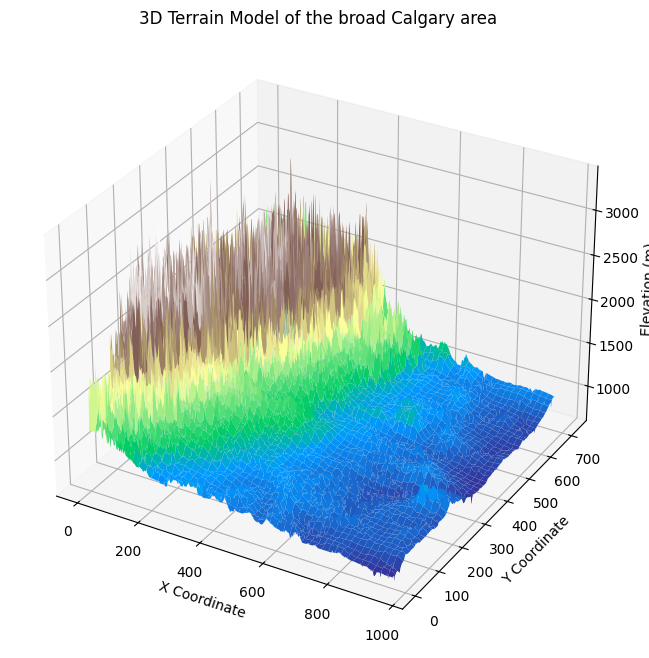

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

elevation = bands_array[0]
nrows, ncols = elevation.shape
x = np.linspace(0, ncols, ncols)
y = np.linspace(0, nrows, nrows)
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, elevation, cmap='terrain', edgecolor='none')

ax.set_title("3D Terrain Model of the broad Calgary area")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Elevation (m)")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

def load_nc_data(file_path):
    data = xr.open_dataset(file_path)
    return data.to_dataframe().reset_index()

def preprocess_data(weather_data, terrain_data):

    merged_data = weather_data.merge(terrain_data, on=["latitude", "longitude"])
    return merged_data

def train_fire_prediction_model(data):

    X = data[['uwnd', 'vwnd', 'rhum', 'air', 'hgt']]
    y = data['fire_occurred']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the fire prediction model: {accuracy}")
    return model

def simulate_smoke_dispersion(data, fire_model):

    data['fire_probability'] = fire_model.predict_proba(data[['uwnd', 'vwnd', 'rhum', 'air', 'hgt']])[:, 1]

    def gaussian_dispersion(fire_prob, wind_speed, distance):
        return fire_prob * np.exp(-distance / (2 * wind_speed))

    data['wind_speed'] = np.sqrt(data['uwnd']**2 + data['vwnd']**2)
    data['smoke_concentration'] = gaussian_dispersion(
        data['fire_probability'], data['wind_speed'], distance=1
    )
    return data

def train_smoke_prediction_system(weather_data, terrain_data, fire_labels):

    data = preprocess_data(weather_data, terrain_data)
    data['fire_occurred'] = fire_labels

    fire_model = train_fire_prediction_model(data)

    final_data = simulate_smoke_dispersion(data, fire_model)

    X = final_data[['fire_probability', 'wind_speed', 'rhum', 'air', 'hgt']]
    y = final_data['smoke_concentration']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    smoke_model = RandomForestRegressor(n_estimators=100, random_state=42)
    smoke_model.fit(X_train, y_train)

    y_pred = smoke_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE of the smoke prediction model: {mse}")
    return smoke_model

def predict_real_time(weather_data, terrain_data, smoke_model):

    data = preprocess_data(weather_data, terrain_data)
    predictions = smoke_model.predict(data[['fire_probability', 'wind_speed', 'rhum', 'air', 'hgt']])
    data['predicted_smoke_concentration'] = predictions
    return data

uwnd_data = load_nc_data("/content/drive/My Drive/WildFire/DATA/NOAA_Climate/uwnd.2024.nc")
vwnd_data = load_nc_data("/content/drive/My Drive/WildFire/DATA/NOAA_Climate/vwnd.2024.nc")
rhum_data = load_nc_data("/content/drive/My Drive/WildFire/DATA/NOAA_Climate/rhum.2024.nc")
air_data = load_nc_data("/content/drive/My Drive/WildFire/DATA/NOAA_Climate/air.2024.nc")
hgt_data = load_nc_data("/content/drive/My Drive/WildFire/DATA/NOAA_Climate/hgt.2024.nc")

fire_labels = pd.read_csv("fire_labels.csv")['fire_occurred']

smoke_model = train_smoke_prediction_system(weather_data, terrain_data, fire_labels)

real_time_data = predict_real_time(weather_data, terrain_data, smoke_model)